# 자전거 대여 수요 측정하기
## 데이터 필드
* datetime 
    - 연도-월-일-시간
* season 
    - 1 = 봄, 
    - 2 = 여름
    - 3 = 가을
    - 4 = 겨울 
* holiday 
    - 0 = 공휴일
    - 1= 비공휴일
* workingday
    - 0 = 평일(주말 또는 휴일 아님)
    - 1 = 평일 아님
* weather 
    - 1: 맑음 + 구름 거의 없음 + 구름 약간 
    - 2: 옅은 안개 + 구름 + 구름 약간과 옅은 안개 
    - 3: 가벼운 눈 또는 비 + 가벼운 비 후 개임 + 흐트러진 구름(scattered clouds) 
    - 4: 호우 + 빙판 + 뇌우 + 짙은 안개와 눈 + 짙은 안개
    - 1에서 4로 갈 수록 날씨가 좋지 않다
* temp 
    - 섭씨온도
* atemp
    - 체감온도
* humidity 
    - 습도
* windspeed 
    - 풍속
* casual 
    - 등록되지 않은 비회원의 대여 수
* registered 
    - 등록된 회원의 대여 수
* count 
    - 총 대여 수


## 평가 방식
제출 한 결과들은 RMSLE(Root Mean Squared Logarithmic Error)로 평가한다.
과대평가된 항목보다는, 과소평가된 항목에 패널티를 주는 평가 방식이다. 
값이 적을수록 오류가 적다는 것을 의미한다.
$$ \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 } $$


## 진행 단계
* 1) 훈련, 테스트 데이터셋의 형태 및 컬럼의 속성 데이터 값 파악
* 2) 데이터 전처리 및 시각화
* 3) 회귀모델 적용
* 4) 결론 도출

## -----------------------------------------------------------------------------------------------------------------------

## 1. 훈련, 테스트 데이터셋의 형태 및 컬럼의 속성 데이터 값 파악

In [70]:
# 필요 라이브러리들 호출

# warning을 무시
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# 데이터 시각화와 실험을 위해
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import calendar 
from datetime import datetime

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에 한글이 표시할 수 있기 위해
import platform
path = "c:/Windows/Fonts/HYGPRM.TTF"
from matplotlib import font_manager, rc
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~') # 한글 표시를 위함

In [71]:
# 훈련 데이터 셋과 테스트 데이터 셋을 불러온다
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [72]:
# 훈련 데이터 셋의 개괄적인 모형 파악
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [73]:
# 훈련 데이터셋의 각 컬럼별 데이터 타입 및 값의 갯수 파악
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


In [74]:
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

각 컬럼 모두 비어있는 데이터 없이 모두 10886개의 데이터로 채워져있다

In [75]:
# 테스트 데이터 셋의 개괄적인 형태 출력
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [76]:
test.columns.unique()

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed'],
      dtype='object')

훈련 데이터 셋과 달리, 테스트 데이터 셋에는 casual, registered, count 컬럼이 없다.

## 2.데이터 전처리 및 시각화

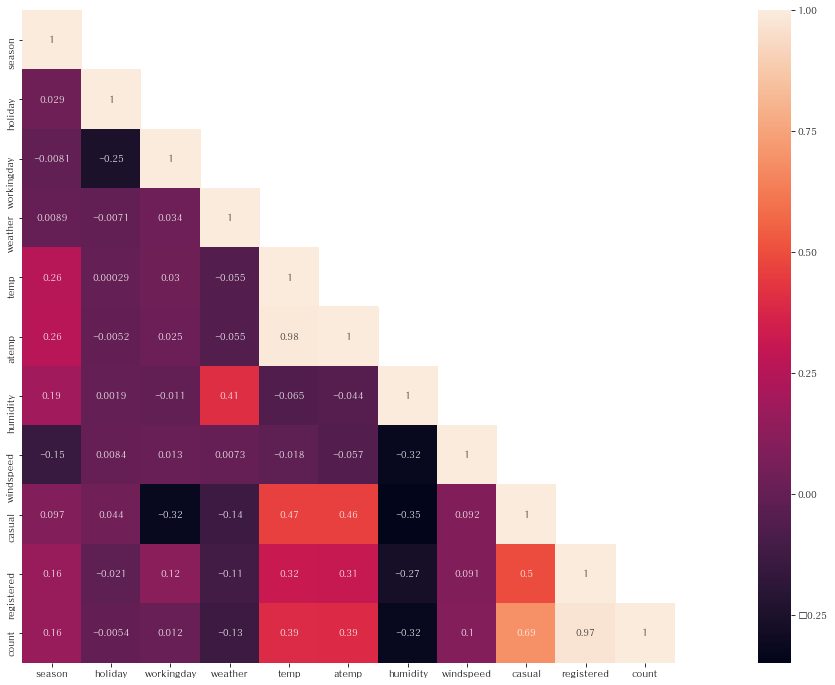

In [81]:
# 데이터 전처리를 진행하기 전에, 각 컬럼간의 연관관계를 시각화로 나타내보아
# 전처리 필요성을 느껴본다
cor_mat= train[:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

* 검은쪽으로 진할 수록 연관관계가 낮다.
* 자기 자신과의 연관관계는 1이다.
* 온도, 습도, 풍속은 거의 연관관계가 없다. 
* 대여량과 가장 연관이 높은 건 registered 로 등록 된 대여자가 많지만, 테스트 데이터 셋에는 이 값이 없다.
* atemp와 temp는 0.98로 상관관계가 높지만 온도와 체감온도로 피처로 사용하기에 적합하지 않을 수 있다.
* 데이터 전처리를 하지 않은 상태에서 연관관계를 파악하기 힘들다.

In [62]:
# 년-월-일-시(hour) 를 분리한다
# 분(minute),초(second) 분리하지 않는 이유는 모든 데이터가 동일하게 0이기 때문이다
train.datetime = train.datetime.apply(pd.to_datetime)
train['year'] = train.datetime.apply(lambda x : x.year)
train['month'] = train.datetime.apply(lambda x : x.month)
train['day'] = train.datetime.apply(lambda x : x.day)
train['hour'] = train.datetime.apply(lambda x : x.hour)
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,hour,year,day
0,2011-01-01 00:00:00,4,0,0,1,9.84,14.395,81,0.0,3,13,16,1,0,2011,1
1,2011-01-01 01:00:00,4,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1,2011,1
2,2011-01-01 02:00:00,4,0,0,1,9.02,13.635,80,0.0,5,27,32,1,2,2011,1
3,2011-01-01 03:00:00,4,0,0,1,9.84,14.395,75,0.0,3,10,13,1,3,2011,1
4,2011-01-01 04:00:00,4,0,0,1,9.84,14.395,75,0.0,0,1,1,1,4,2011,1


[Text(0.5,0,'hour'), Text(0.5,1,'시간별 대여량')]

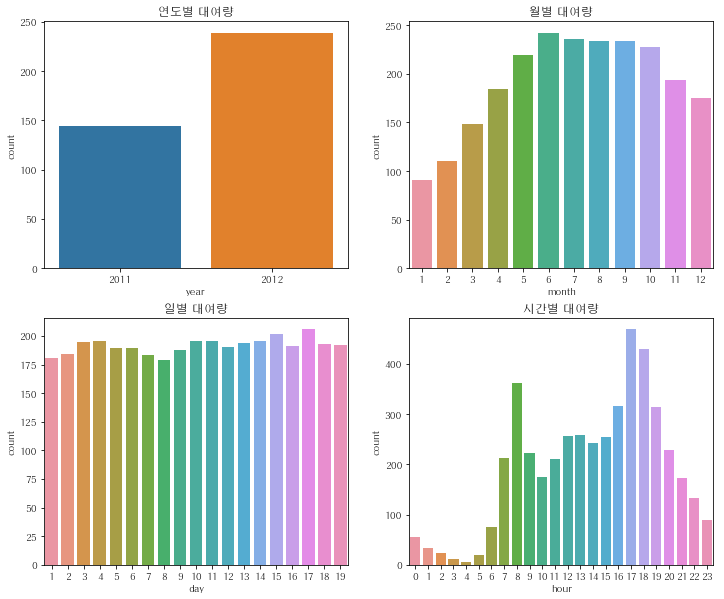

In [33]:
#각각의 속성과 예측의 결과값으로 쓰이는 count값과의 관계 파악

fig = plt.figure(figsize=[12,10])

#년도와 count
ax1 = fig.add_subplot(2,2,1)
ax1 = sns.barplot(x='year',y='count',data=train.groupby('year')['count'].mean().reset_index())
ax1.set(title="연도별 대여량")

#month와 count
ax2 = fig.add_subplot(2,2,2)
ax2 = sns.barplot(x='month',y='count',data=train.groupby('month')['count'].mean().reset_index())
ax2.set(title="월별 대여량")

#day와 count
ax3 = fig.add_subplot(2,2,3)
ax3 = sns.barplot(x='day',y='count',data=train.groupby('day')['count'].mean().reset_index())
ax3.set(title="일별 대여량")

#hour와 count
ax4 = fig.add_subplot(2,2,4)
ax4 = sns.barplot(x='hour',y='count',data=train.groupby('hour')['count'].mean().reset_index())
ax4.set(xlabel='hour', title="시간별 대여량")

- 연도별 대여량 : 2011년 보다 2012년이 더 많아 증가하였다.
- 월별 대여량 : 6월에 가장 많고, 7~10월도 많다. 1월이 가장 적다.
- 일별 대여량 : 1~19일 까지만 데이터가 존재하기 때문에 이 데이터는 피처로 사용할 수 없다.
- 시간별 대여량 : 출퇴근 시간에 가장 많다. 따라서, 주말의 데이터도 나누어 보아야할 것 같다.

In [38]:
# season에 이상이 있어 전처리

# 1월의 데이터에서 season 컬럼이 1, 즉 봄으로 나타나있다
# 데이터는 미국 워싱턴의 데이터로, 계절 변화가 우리나라와 비슷하다
# 따라서 1월은 겨울이므로 4, 즉 겨울로 바꿔야한다

def wrongSeason(month):
    if month in [12,1,2]:
        return 4
    elif month in [3,4,5]:
        return 1
    elif month in [6,7,8]:
        return 2
    elif month in [9,10,11]:
        return 3

train['season'] = train.month.apply(wrongSeason)
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,hour,year,day
0,2011-01-01 00:00:00,4,0,0,1,9.84,14.395,81,0.0,3,13,16,1,0,2011,1
1,2011-01-01 01:00:00,4,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1,2011,1
2,2011-01-01 02:00:00,4,0,0,1,9.02,13.635,80,0.0,5,27,32,1,2,2011,1
3,2011-01-01 03:00:00,4,0,0,1,9.84,14.395,75,0.0,3,10,13,1,3,2011,1
4,2011-01-01 04:00:00,4,0,0,1,9.84,14.395,75,0.0,0,1,1,1,4,2011,1


[Text(0.5,1,'날씨별 대여량')]

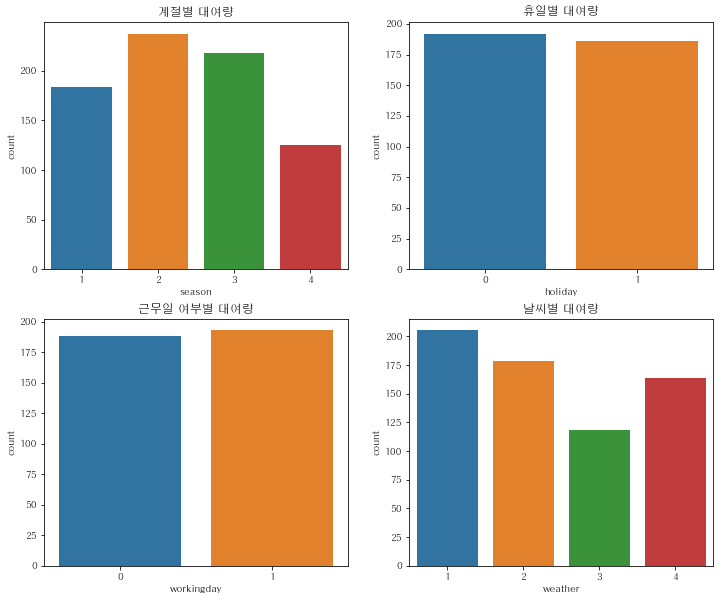

In [50]:
#계절과 count
fig = plt.figure(figsize=[12,10])
ax1 = fig.add_subplot(2,2,1)
ax1 = sns.barplot(x='season',y='count',data=train.groupby('season')['count'].mean().reset_index())
ax1.set(title="계절별 대여량")

#휴일 여부와 count
ax2 = fig.add_subplot(2,2,2)
ax2 = sns.barplot(x='holiday',y='count',data=train.groupby('holiday')['count'].mean().reset_index())
ax2.set(title="휴일별 대여량")

#근무일 여부와 count
ax3 = fig.add_subplot(2,2,3)
ax3 = sns.barplot(x='workingday',y='count',data=train.groupby('workingday')['count'].mean().reset_index())
ax3.set(title="근무일 여부별 대여량")

#날씨와 count
ax4 = fig.add_subplot(2,2,4)
ax4 = sns.barplot(x='weather',y='count',data=train.groupby('weather')['count'].mean().reset_index())
ax4.set(title="날씨별 대여량")

In [53]:
train.weather.value_counts()

1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64

- 계절별 대여량 : 여름과 가을에 가장 대여량이 많고, 겨울에 가장 대여량이 적다
- 휴일별 대여량, 근무일 여부별 대여량 : 대여량은 휴일과 근무일 여부에 상관없이 비슷하게 나타난다
- 날씨별 대여량 : 가장 안좋은 날씨(4)의 데이터가 하나 밖에 없어 비교하기에 애매하다.

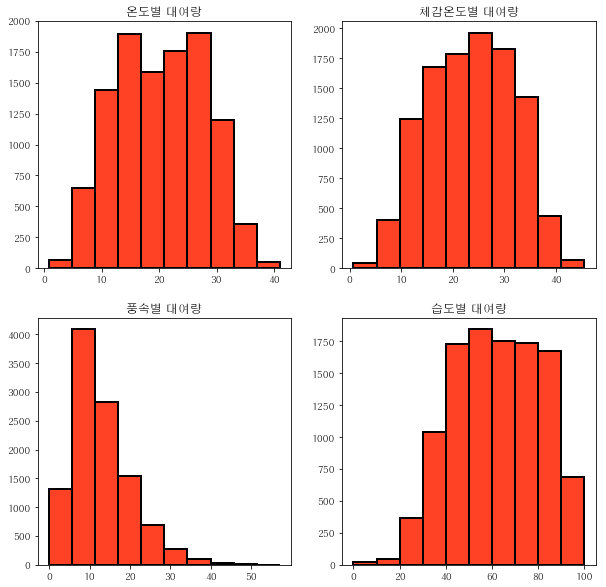

In [58]:
#다른 컬럼들과 count와 비교

train.temp.unique()
fig,axes=plt.subplots(2,2)

# 온도와 count
axes[0,0].hist(x="temp",data=train,edgecolor="black",linewidth=2,color='#ff4125')
axes[0,0].set_title("온도별 대여랑")
# 체감온도와 count
axes[0,1].hist(x="atemp",data=train,edgecolor="black",linewidth=2,color='#ff4125')
axes[0,1].set_title("체감온도별 대여량")
# 풍속과 count
axes[1,0].hist(x="windspeed",data=train,edgecolor="black",linewidth=2,color='#ff4125')
axes[1,0].set_title("풍속별 대여량")
# 습도와 count
axes[1,1].hist(x="humidity",data=train,edgecolor="black",linewidth=2,color='#ff4125')
axes[1,1].set_title("습도별 대여량")
fig.set_size_inches(10,10)

* 풍속의 경우 0에 숫자가 몰려 있는 것으로 보인다. 아마도 관측되지 않은 수치에 대해 0으로 기록된 것이 아닐까 추측해 본다.

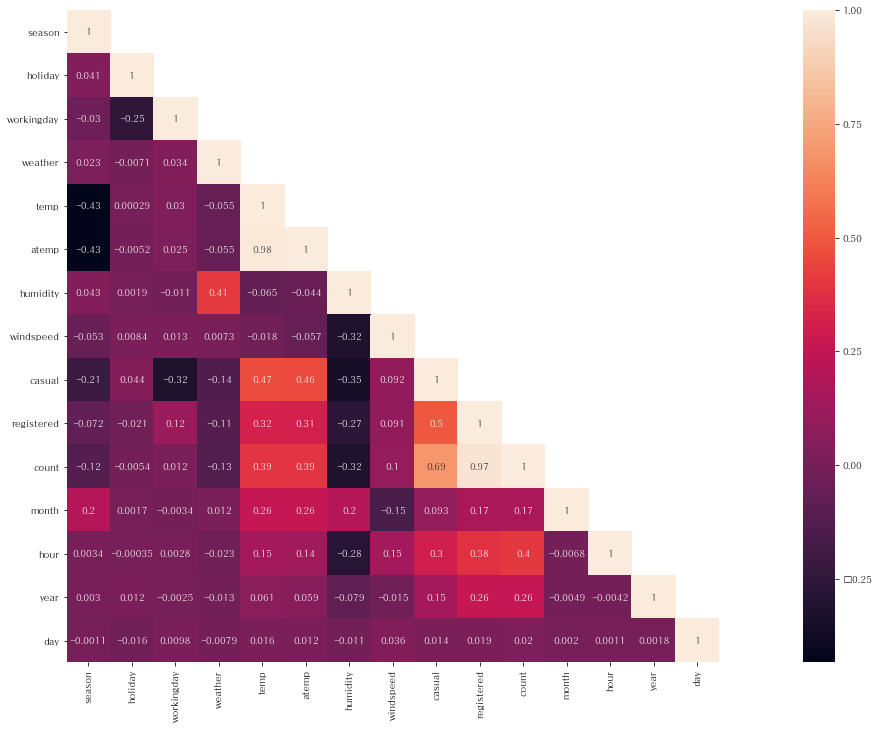

In [67]:
#각각의 컬럼들 간의 상관계수를 heatmap을 통해 시각화

cor_mat= train[:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

* 검은쪽으로 진할 수록 연관관계가 낮다.
* 자기 자신과의 연관관계는 1이다.
* 온도, 습도, 풍속은 거의 연관관계가 없다. 
* 대여량과 가장 연관이 높은 건 registered 로 등록 된 대여자가 많지만, test 데이터에는 이 값이 없다.
* atemp와 temp는 0.98로 상관관계가 높지만 온도와 체감온도로 피처로 사용하기에 적합하지 않을 수 있다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 16 columns):
datetime      10886 non-null datetime64[ns]
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
month         10886 non-null int64
hour          10886 non-null int64
year          10886 non-null int64
day           10886 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(12)
memory usage: 1.3 MB
